<a id="Comparing_Transforms"></a>
## Comparing the Image Transformation Types

In this post, we will compare the Discrete Cosine Transform (DCT) and the FFT in terms of which of the transform packs the most information in the least amount of coefficients. We will also use the same comparison to square-waveform-based transforms such as the Walsh or the Haar transform that are already implemented previously. We will gauge the difference between the original image and the reconstructed one form the few coefficients you kept. We will perform pixel by pixel difference between the original image and the reconstructed images to see which one gives the best mean-square-error for the same cut-off frequency (or amount coefficients kept).

Let's first import the common classes.

In [15]:
from CommonClasses.fft import *
from CommonClasses.dct import *
from CommonClasses.walsh import *
from CommonClasses.haar import *

import numpy as np

import matplotlib.pyplot as plt
#%matplotlib inline

#import matplotlib.image as img
#import PIL.Image as Image 
from PIL import Image
import math
import cmath

import time

import csv

from numpy import binary_repr

from fractions import gcd

In [16]:
def countNonZeroCoefficients(imge):
    """Counts the total number of non-zero coefficients."""
    imge = imge.astype(int)
    total = np.sum((np.absolute(imge)>0).astype(int))
    return total

In [17]:
def IdentifyLargestCoefficients(imge, n, dtype='real'):
    """Constructs matrix that keeps the n largest coefficients and makes all others to zero."""
    
    N = imge.shape[0]
    result = np.zeros(N**2, dtype=int)
            
    # Flatten the 2-D image matrix
    imgeFlat = imge.reshape(N**2)
    
    # Find the indices of the n largest coefficients
    ind = np.argsort(imgeFlat)[-n:]
    
    #Make those as 1 to keep them
    result[ind] = 1
    
    if dtype != 'real':
        result = np.zeros(N**2, dtype=complex)
        result[ind] = 1+1j

    #Reshape the result and return it.
    return result.reshape([N, N])

In [18]:
def findImgeWithLargeCoefficients(imge, coeffMat):
    """Finds the image having only the largest coefficients based on the coeffMat matrix."""
    
    imgeReduced = imge * coeffMat
    
    return imgeReduced

In [19]:
def calculateRMSE(origImge, recImge):
    """Calculates the Root Mean Square Error (RMSE) between the original image(origImge)
       and recovered image(recImge)"""
    rmse = math.sqrt(np.sum((origImge - recImge)**2))
    return rmse

In [20]:
imgeCameraman = Image.open("Images/lena_gray_64.tif") # open an image
imgeCameraman = imgeCameraman.convert(mode='L')

imgeCameraman = np.array(imgeCameraman).astype(int)

#imgeCameraman = np.array(imgeCameraman)
#imgeCameraman = Images.generateBlackAndWhiteSquareImage(64)

In [21]:
N = imgeCameraman.shape[0]
imgCamFFTInv = np.absolute(FFT.computeFFT(imgeCameraman)*N).astype(int)

#Count the number of non zero coefficients
np.sum((imgCamFFTInv>0).astype(int))

4082

In [22]:
#Calculate the transforms
imgCamFFT = FFT.computeFFT(imgeCameraman)

In [23]:
imgCamDCT = DCT.computeForward2DDCT(imgeCameraman)

In [24]:
imgCamWal = Walsh.computeForwardWalsh(imgeCameraman)

In [25]:
imgCamHaar = Haar.computeForwardHaar(imgeCameraman)

In [26]:
#Count the number of non-zero coefficients from the transformed images.
fftSpectrum = np.absolute(imgCamFFT)
numCoeff_FFT = countNonZeroCoefficients(fftSpectrum)
numCoeff_DCT = countNonZeroCoefficients(imgCamDCT)
numCoeff_Wal = countNonZeroCoefficients(imgCamWal)
numCoeff_Haar = countNonZeroCoefficients(imgCamHaar*(N**2))

print "Total Number of Non-Zero Coefficients:"
print "--------------------------------------"
print "FFT: ", numCoeff_FFT
print "DCT: ", numCoeff_DCT
print "Walsh: ", numCoeff_Wal
print "Haar: ", numCoeff_Haar

Total Number of Non-Zero Coefficients:
--------------------------------------
FFT:  291
DCT:  3910
Walsh:  3961
Haar:  4004


In [27]:
#Number of coefficients to be retained in the image (all others will be zero)
n_coeffs = [10, 100, 200, 300, 500]
#n_coeffs = 4096
rmses = np.zeros([4, len(n_coeffs)])
imges = [imgCamFFT, imgCamDCT, imgCamWal, imgCamHaar]
for i, imge in enumerate(imges):
    for j, n_coeff in enumerate(n_coeffs):
        
        N = imge.shape[0]
        #If complex numbers...
        if i==0:
            imge2 = np.absolute(imge)
            H = IdentifyLargestCoefficients(imge2, n_coeff, 'complex')
            recImge = H * imge
            #Compute the Inverse Transform
            recImgeInv = FFT.computeInverseFFT(recImge)/N
        elif i==1:
            H = IdentifyLargestCoefficients(imge, n_coeff)
            recImge = H * imge
            #Compute the Inverse Transform
            recImgeInv = DCT.computeInverse2DDCT(recImge)
        elif i==2:
            H = IdentifyLargestCoefficients(imge, n_coeff)
            recImge = H * imge
            #Compute the Inverse Transform
            recImgeInv = Walsh.computeInverseWalsh(recImge)
        else:
            H = IdentifyLargestCoefficients(imge, n_coeff)
            recImge = H * imge
            #Compute the Inverse Transform
            recImgeInv = Haar.computeInverseHaar(recImge)*(N**2)
            
        #Calculate the RMSE between the original and the recovered images
        rmses[i, j] = calculateRMSE(imgeCameraman, recImgeInv)

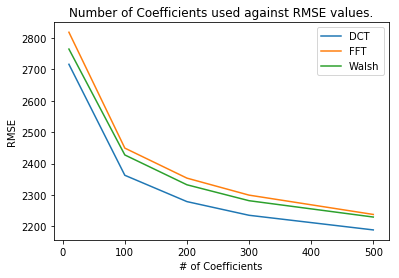

In [31]:
#Visualize the above results graphically.
for i in range(rmses.shape[0]):
    if i==0:
        continue
    rmse = rmses[i, :]
    plt.plot(n_coeffs, rmse)
    #plt.hold(True)
    
plt.title('Number of Coefficients used against RMSE values.')
plt.xlabel('# of Coefficients')
plt.ylabel('RMSE')
plt.legend(['DCT', 'FFT', 'Walsh'], loc=1)
plt.show()

From the above graph, we can conclude that as the number of coeffients increases, the error decreases. And DCT has more compact number of coefficients because we could get more information with same number of coefficients as the other transforms.